In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import denoising
import utils
import importlib
import glob
utils = importlib.reload(utils)
plt.rcParams['text.usetex'] = True


In [75]:
def downsample(image):
    func = utils.downsample_by_four
    return func(image)
    # return func(func(image))

def margin_crop(image):
    """
    Crops the image to a central square region of shape (target_size, target_size).

    Args:
        image (np.ndarray or torch.Tensor): Input image of shape (H, W) or (1, H, W).
        target_size (int): Desired size of the central square region to keep.

    Returns:
        Cropped image of shape (target_size, target_size) or (1, target_size, target_size).
    """

    H, W = image.shape[-2:]

    target_size = H - 2**3


    assert H == W, "Image must be square"
    assert target_size <= H, "Target size must be smaller than or equal to image size"

    margin = (H - target_size) // 2
    cropped = image[..., margin:margin + target_size, margin:margin + target_size]
    return cropped
    # return image

def low_pass_filter(image, k_max):
    if k_max is not None:
        H, W = image.shape
        kx = np.fft.fftfreq(W) * W
        ky = np.fft.fftfreq(H) * H
        kx, ky = np.meshgrid(kx, ky)
        k_squared = kx**2 + ky**2

        # Fourier transform
        image_fft = np.fft.fft2(image)
        
        # Apply mask
        mask = k_squared <= k_max**2
        image_fft_filtered = image_fft * mask
        
        # Inverse transform
        return np.fft.ifft2(image_fft_filtered).real
    else:
        return image

In [76]:
# Define patch number
k_max = None
patch = "166"
base_path = f"/Users/tsouros/Desktop/Planck data/BK_CMB_S4_north_patch/"

In [77]:
# Get sorted list of file paths from Stokes_Q and Stokes_U directories
nuisance_Q = sorted(glob.glob(f"{base_path}nuisance/patch_{patch}/Stokes_Q/patch_{patch}_noise_Q*.npy"))
nuisance_U = sorted(glob.glob(f"{base_path}nuisance/patch_{patch}/Stokes_U/patch_{patch}_noise_U*.npy"))

# Load and downsample
contamination_arr_Q = np.stack([margin_crop(downsample(np.load(f)))[None, :, :] for f in nuisance_Q], axis=0)
contamination_arr_U = np.stack([margin_crop(downsample(np.load(f)))[None, :, :] for f in nuisance_U], axis=0)

# Stack into shape (N_maps, 2, 768, 768)
nuisance = np.stack([contamination_arr_Q, contamination_arr_U], axis=1)
nuisance = nuisance.squeeze(axis=2)

In [78]:
# Find the file using a wildcard
i_path = glob.glob(f"{base_path}signal/patch_{patch}/patch_{patch}_I*.npy")[0]
q_path = glob.glob(f"{base_path}signal/patch_{patch}/patch_{patch}_Q*.npy")[0]
u_path = glob.glob(f"{base_path}signal/patch_{patch}/patch_{patch}_U*.npy")[0]

q_path_GNILC = glob.glob(f"{base_path}GNILC/Q_GNILC_PR3_patch_{patch}_*.npy")[0]
u_path_GNILC = glob.glob(f"{base_path}GNILC/U_GNILC_PR3_patch_{patch}_*.npy")[0]

# Load it
data_I = np.load(i_path)
data_I = margin_crop(downsample(data_I))

# Load it
data_Q = np.load(q_path)
data_Q = margin_crop(downsample(data_Q))

# Load it
data_U = np.load(u_path)
data_U = margin_crop(downsample(data_U))

Q_GNILC = np.load(q_path_GNILC)
Q_GNILC = margin_crop(downsample(Q_GNILC))

U_GNILC = np.load(u_path_GNILC)
U_GNILC = margin_crop(downsample(U_GNILC))

In [79]:
denoised = np.load(f"/Users/tsouros/Desktop/ScatteringDenoising/image_denoised_patch_{patch}_test.npy")

In [80]:
# image_I, image_Q, image_U = denoised[0], denoised[1], denoised[2]
image_Q, image_U = margin_crop(denoised[0]), margin_crop(denoised[1])
image_Q = low_pass_filter(image_Q, k_max = k_max)
image_U = low_pass_filter(image_U, k_max = k_max)

In [81]:
def plot_PS(stokes, image_Q, image_U, data_Q, data_U, Q_GNILC, U_GNILC, nuisance, k_max):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))

    if stokes == 'Q':
        image = image_Q
        data = data_Q
        gnilc = Q_GNILC
        nuisances = nuisance[:, 0]
    else:
        image = image_U
        data = data_U
        gnilc = U_GNILC
        nuisances = nuisance[:, 1]

    nx, ny = data.shape
    lam = 0.55
    image = denoising.filter_radial(np.array([image]), lambda k: k < nx * lam)[0]

    # Compute power spectra
    k_data, P_data = utils.power_spectrum(data)
    k_image, P_image = utils.power_spectrum(image)
    k_noise, P_noise = utils.power_spectrum(data - image)
    k_gnilc, P_gnilc = utils.power_spectrum(gnilc)

    # Nuisance
    k_all_c, P_c_all = zip(*[utils.power_spectrum(c) for c in nuisances])
    k_ref = np.array(k_all_c[0])
    P_c_all = np.array(P_c_all)
    P_c_mean = np.mean(P_c_all, axis=0)
    P_c_std = np.std(P_c_all, axis=0)

    # s + c
    k_all_sc, P_sc_all = zip(*[utils.power_spectrum(image + c) for c in nuisances])
    P_sc_all = np.array(P_sc_all)
    P_sc_mean = np.mean(P_sc_all, axis=0)
    P_sc_std = np.std(P_sc_all, axis=0)

    def trim(k, P):
        if k_max is not None:
            mask = k_ref < k_max
            return k[mask], P[mask]
        else:
            return k, P

    k_data, P_data = trim(k_data, P_data)
    k_image, P_image = trim(k_image, P_image)
    k_noise, P_noise = trim(k_noise, P_noise)
    k_gnilc, P_gnilc = trim(k_gnilc, P_gnilc)
    k_mean, P_sc_mean = trim(k_ref, P_sc_mean)
    _, P_sc_std = trim(k_ref, P_sc_std)
    _, P_c_mean = trim(k_ref, P_c_mean)
    _, P_c_std = trim(k_ref, P_c_std)

    # Plot
    plt.loglog(k_data, P_data, label=r"$d$", c="r")
    plt.loglog(k_image, P_image, label=r"$\tilde{s}$", c="b")
    plt.loglog(k_noise, P_noise, label=r"$d - \tilde{s}$", c="orange")
    plt.loglog(k_gnilc, P_gnilc, label=r"GNILC", c="k")
    plt.loglog(k_mean, P_sc_mean, label=r"$\langle \tilde{s} + c \rangle$", c="c")
    plt.fill_between(
        k_mean,
        P_sc_mean - P_sc_std,
        P_sc_mean + P_sc_std,
        color="c",
        alpha=0.3,
        linewidth=0,
        label=r"$\langle \tilde{s} + c \rangle \pm \sigma$"
    )
    plt.loglog(k_mean, P_c_mean, label=r"$\langle c \rangle$", c="g")
    plt.fill_between(
        k_mean,
        P_c_mean - P_c_std,
        P_c_mean + P_c_std,
        color="g",
        alpha=0.3,
        linewidth=0,
        label=r"$\langle c \rangle \pm \sigma$"
    )

    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(fr"Stokes-${stokes}$")
    plt.legend()
    plt.show()

In [82]:
def plot_CS(stokes, image_Q, image_U, data_Q, data_U, nuisance, k_max=20):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))

    if stokes == 'Q':
        image = image_Q
        data = data_Q
        nuisances = nuisance[:, 0]
    else:
        image = image_U
        data = data_U
        nuisances = nuisance[:, 1]

    nx, ny = data.shape
    lam = 0.55
    image_filtered = denoising.filter_radial(np.array([image]), lambda k: k < nx * lam)[0]

    # Cross-spectrum with residual
    residual = data - image_filtered
    k_res, P_cross_residual = utils.cross_spectrum(image_filtered, residual)

    # Cross-spectra with each nuisance realization
    k_all, cs_all = zip(*[utils.cross_spectrum(image_filtered, c) for c in nuisances])
    k_mean = np.array(k_all[0])  # common k array
    cs_all = np.array(cs_all)
    cs_mean = np.mean(cs_all, axis=0)
    cs_std = np.std(cs_all, axis=0)

    # Trim helper
    def trim(k, P):
        mask = k < k_max
        return k[mask], P[mask]

    # Trim all
    k_res, P_cross_residual = trim(k_res, np.abs(P_cross_residual))
    k_mean_trim, cs_mean = trim(k_mean, np.abs(cs_mean))
    _, cs_std = trim(k_mean, cs_std)

    # Plot
    plt.loglog(k_res, P_cross_residual, label=r"$|\tilde{s} \times (d - \tilde{s})|$", c="m")
    plt.loglog(k_mean_trim, cs_mean, label=r"$|\langle \tilde{s} \times c \rangle|$", c="orange")
    plt.fill_between(
        k_mean_trim,
        cs_mean - cs_std,
        cs_mean + cs_std,
        color="orange",
        alpha=0.3,
        linewidth=0,
        label=r"$\langle \tilde{s} \times c \rangle \pm \sigma$"
    )

    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P_{\times}(k)$", fontsize=16)
    plt.title(fr"Cross-spectra: Stokes-${stokes}$", fontsize=16)
    plt.legend()
    plt.show()

In [83]:
def plot_maps(stokes, image_Q, image_U, data_Q, data_U, Q_GNILC, U_GNILC, ran):
    # Select appropriate Stokes fields
    if stokes == 'Q':
        image = image_Q
        data = data_Q
        gnilc = Q_GNILC
        c_i = nuisance[np.random.randint(ran), 0]
    else:
        image = image_U
        data = data_U
        gnilc = U_GNILC
        c_i = nuisance[np.random.randint(ran), 1]

    # Compute combined map
    combined = data + c_i

    # Common settings
    cmap = 'magma'
    color = 'white'

    # Determine global color limits across all maps
    vmin = min(data.min(), image.min(), combined.min(), gnilc.min())
    vmax = max(data.max(), image.max(), combined.max(), gnilc.max())

    # Set up figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    fig.patch.set_alpha(0)

    # Enable LaTeX
    plt.rcParams['text.usetex'] = True

    # Plot maps
    titles = [r"$d$", r"$\tilde{s}$", r"$\tilde{s} + c_i$", r"GNILC"]
    maps = [data, image, combined, gnilc]

    for ax, title, m in zip(axes.flat, titles, maps):
        im = ax.imshow(m, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=16, color=color)
        ax.axis('off')

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label(r"$MJy/sr$", fontsize=20, color=color)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=color)

    # Add figure title
    fig.suptitle(fr"Stokes-${stokes}$", fontsize=20, color='white')

    plt.show()

In [84]:
def plot_noise(stokes, image_Q, image_U, data_Q, data_U, nuisance, ran):
    # Select appropriate Stokes fields
    if stokes == 'Q':
        image = image_Q
        data = data_Q
        c_i = nuisance[ran, 0]
    else:
        image = image_U
        data = data_U
        c_i = nuisance[ran, 1]

    # Compute residual
    residual = data - image

    # Common settings
    cmap = 'magma'
    color = 'white'

    # Determine global color limits
    vmin = min(residual.min(), c_i.min())
    vmax = max(residual.max(), c_i.max())


    # Set up figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    fig.patch.set_alpha(0)

    # Enable LaTeX
    plt.rcParams['text.usetex'] = True

    # Plot residual
    axes[0].imshow(residual, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(r"$d - \tilde{s}$", fontsize=16, color=color)
    axes[0].axis('off')

    # Plot c_i
    im1 = axes[1].imshow(c_i, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(r"$c_i$", fontsize=16, color=color)
    axes[1].axis('off')

    # Add colorbar
    cbar = fig.colorbar(im1, ax=axes, orientation="vertical", fraction=0.025, pad=0.02)
    cbar.set_label(r"$MJy/sr$", fontsize=20, color=color)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=color)

    # Add figure title
    # fig.suptitle(fr"Stokes-${stokes}$", fontsize=20, color='white')

    plt.show()

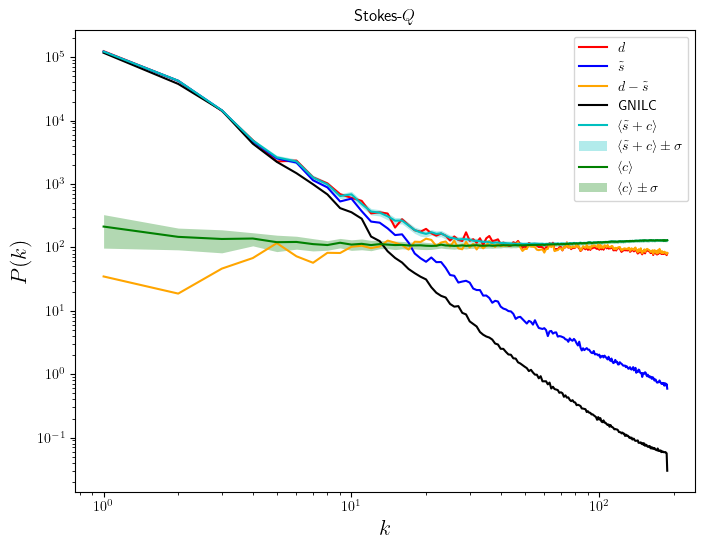

In [85]:
stokes = 'Q'
plot_PS(stokes, image_Q, image_U, data_Q, data_U, Q_GNILC, U_GNILC, nuisance, k_max = k_max)
# plot_CS(stokes, image_Q, image_U, data_Q, data_U, nuisance, k_max = k_max)

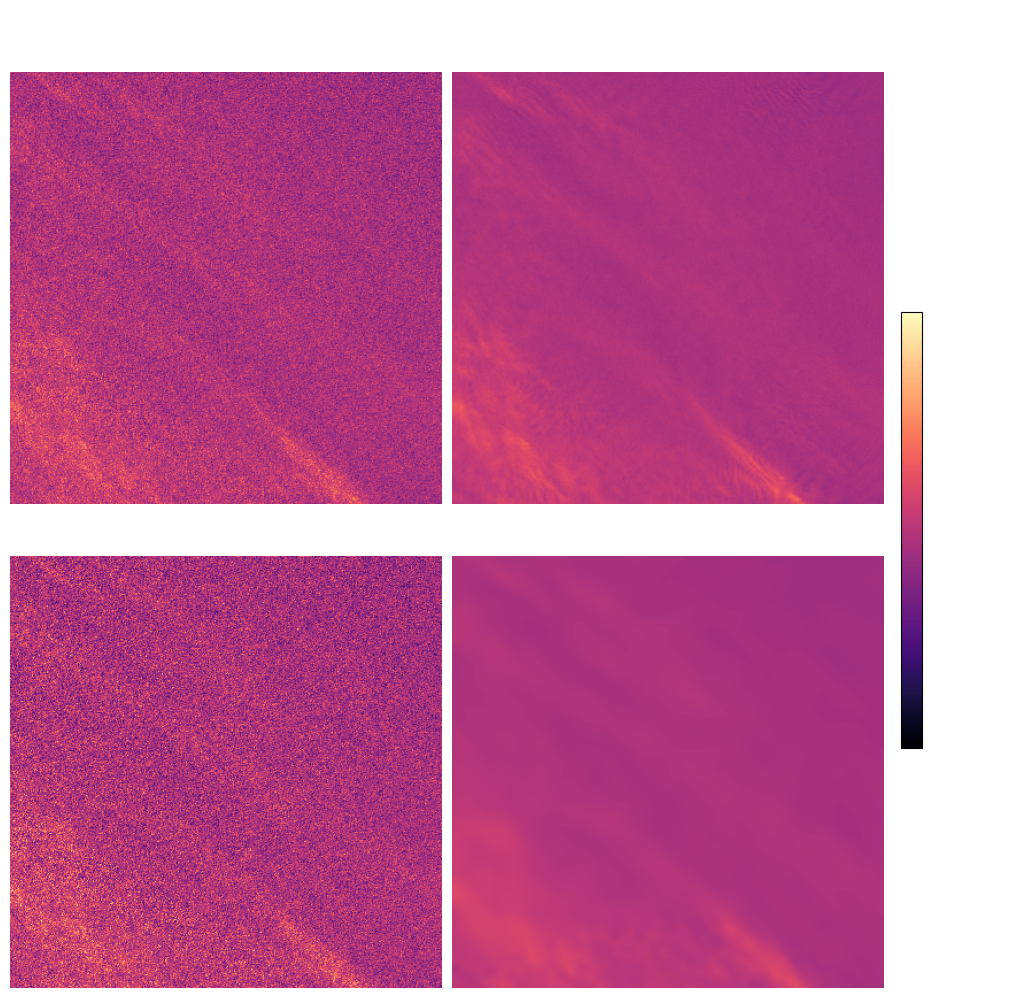

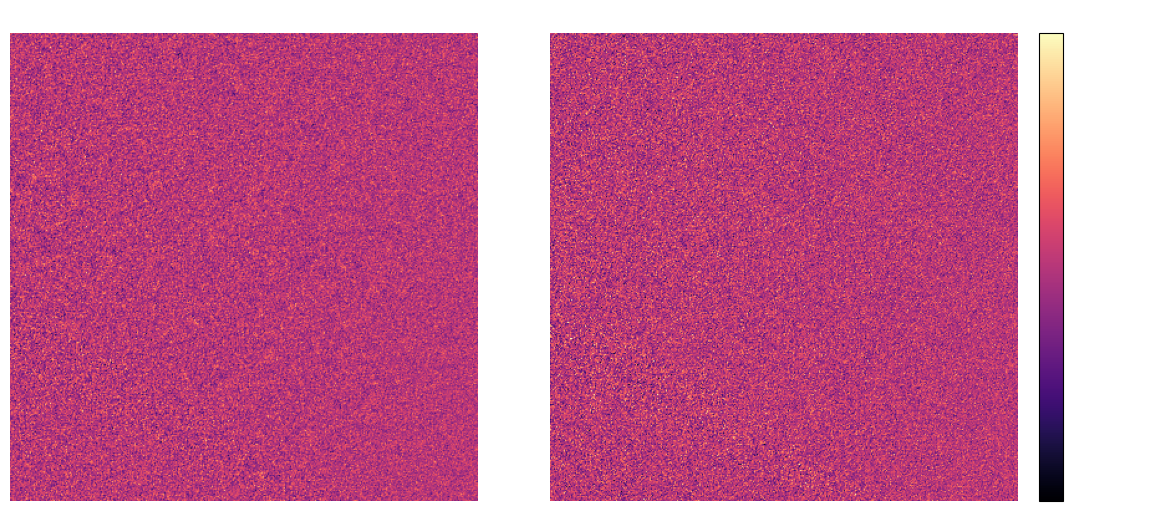

In [86]:
# Plot for both Q and U
ran = np.random.randint(len(nuisance))
plot_maps(stokes, image_Q, image_U, data_Q, data_U, Q_GNILC, U_GNILC, ran)
plot_noise(stokes, image_Q, image_U, data_Q, data_U, nuisance, ran)

In [87]:
def plot_I(image_I, data_I, titles=(r"$s_I$", r"$d_I$")):
    """
    Plots image_I and data_I side by side with a shared colorbar.

    Args:
        image_I (np.ndarray): First image.
        data_I (np.ndarray): Second image.
        titles (tuple): Titles for the subplots.
    """
    vmin = min(image_I.min(), data_I.min())
    vmax = max(image_I.max(), data_I.max())

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    im0 = axes[0].imshow(image_I, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title(titles[0])
    axes[0].axis('off')

    im1 = axes[1].imshow(data_I, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title(titles[1])
    axes[1].axis('off')

    fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.show()